<h1 style='color:purple' align='center'> Regression Project: Predicting Home Prices</h1>

In [56]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

<h2 style='color:black'>Data Load: Load banglore home prices into a dataframe</h2>

In [2]:
df1=pd.read_csv("bengaluru_house_prices.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df1.shape

(13320, 9)

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [5]:
df1.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


In [6]:
df2=df1.drop(['availability','society'],axis='columns')
df2.head()

,area_type,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Built-up Area,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Super built-up Area,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Super built-up Area,Kothanur,2 BHK,1200,2.0,1.0,51.00


<h2 style='color:black'> Handling data error and change datatype of total_sqft and size column </h2>

In [7]:
df2['bhk']=df2['size'].apply(lambda x : int(x.split(' ')[0]) if pd.notna(x) else None)
df2=df2.drop(['size'],axis='columns')
df2.head()

,area_type,location,total_sqft,bath,balcony,price,bhk
0,Super built-up Area,Electronic City Phase II,1056,2.0,1.0,39.07,2.0
1,Plot Area,Chikka Tirupathi,2600,5.0,3.0,120.00,4.0
2,Built-up Area,Uttarahalli,1440,2.0,3.0,62.00,3.0
3,Super built-up Area,Lingadheeranahalli,1521,3.0,1.0,95.00,3.0
4,Super built-up Area,Kothanur,1200,2.0,1.0,51.00,2.0


In [8]:
def convert_sqft_to_num(x):
    if isinstance(x, str):
        # Handle range values like '1000-1200'
        tokens = x.split('-')
        if len(tokens) == 2:
            try:
                return (float(tokens[0]) + float(tokens[1])) / 2
            except ValueError:
                return None
        
        # Remove any non-numeric characters (like 'Sq. Meter') using regex
        try:
            x_clean = re.findall(r"[-+]?\d*\.\d+|\d+", x)[0]  # Extract first numeric value
            return float(x_clean)
        except (ValueError, IndexError):  # Handle cases where no valid number is found
            return None
    else:
        return x

In [9]:
df2['total_sqft']=df2['total_sqft'].apply(convert_sqft_to_num)

In [10]:
df2['location']=df2['location'].fillna('Whitefield')

In [11]:
df2.groupby('bhk')['bhk'].count()

bhk
1.0      656
2.0     5528
3.0     4857
4.0     1417
5.0      356
6.0      221
7.0      100
8.0       89
9.0       54
10.0      14
11.0       4
12.0       1
13.0       1
14.0       1
16.0       1
18.0       1
19.0       1
27.0       1
43.0       1
Name: bhk, dtype: int64

In [12]:
df3=df2.copy()

In [13]:
df3['area_type'] = df3['area_type'].str.replace(r'\s+', ' ', regex=True).str.strip()
df3['location'] = df3['location'].str.replace(r'\s+', ' ', regex=True).str.strip()
categories_order = [['Carpet Area', 'Plot Area', 'Built-up Area','Super built-up Area']]
# Apply Ordinal Encoding
encoder = OrdinalEncoder(categories=categories_order)
df3['area_type'] = encoder.fit_transform(df3[['area_type']])

In [14]:
df3.head()

,area_type,location,total_sqft,bath,balcony,price,bhk
0,3.0,Electronic City Phase II,1056.0,2.0,1.0,39.07,2.0
1,1.0,Chikka Tirupathi,2600.0,5.0,3.0,120.00,4.0
2,2.0,Uttarahalli,1440.0,2.0,3.0,62.00,3.0
3,3.0,Lingadheeranahalli,1521.0,3.0,1.0,95.00,3.0
4,3.0,Kothanur,1200.0,2.0,1.0,51.00,2.0


In [15]:
df3['location'] = df3['location'].str.replace(r'\s+', ' ', regex=True).str.strip()
encoder = LabelEncoder()
df3['location'] = encoder.fit_transform(df3['location'])

In [16]:
df3.head()

,area_type,location,total_sqft,bath,balcony,price,bhk
0,3.0,405,1056.0,2.0,1.0,39.07,2.0
1,1.0,303,2600.0,5.0,3.0,120.00,4.0
2,2.0,1166,1440.0,2.0,3.0,62.00,3.0
3,3.0,743,1521.0,3.0,1.0,95.00,3.0
4,3.0,702,1200.0,2.0,1.0,51.00,2.0


<h2 style='color:black'> Impute missing  values</h2>

In [17]:
imp = IterativeImputer(max_iter=30)
df4=pd.DataFrame(imp.fit_transform(df3),columns=df3.columns)

In [18]:
df4['bhk'] = df4['bhk'].round().astype(int)
df4['balcony'] = df4['balcony'].round().astype(int)
df4['bath'] = df4['bath'].round().astype(int)

In [19]:
df4.head()

,area_type,location,total_sqft,bath,balcony,price,bhk
0,3.0,405.0,1056.0,2,1,39.07,2
1,1.0,303.0,2600.0,5,3,120.00,4
2,2.0,1166.0,1440.0,2,3,62.00,3
3,3.0,743.0,1521.0,3,1,95.00,3
4,3.0,702.0,1200.0,2,1,51.00,2


<Axes: >

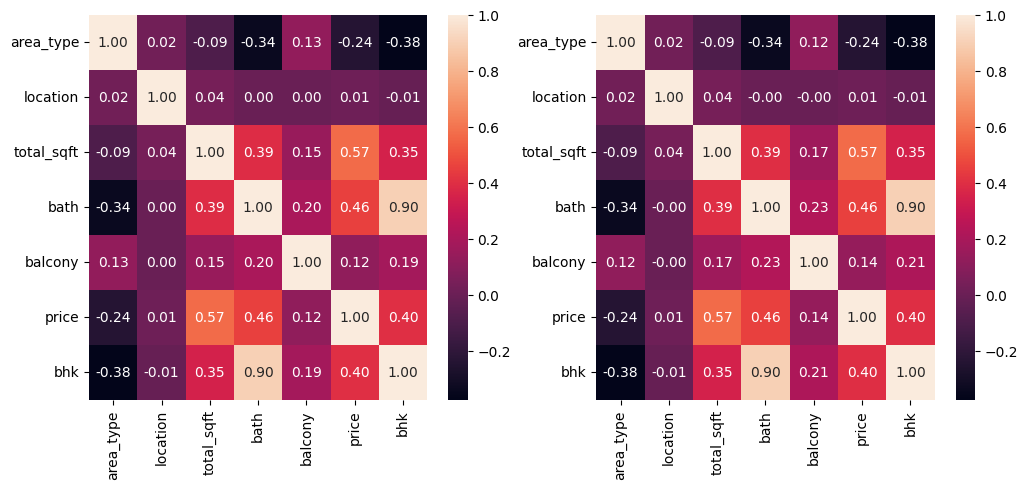

In [20]:
plt.figure(figsize=(12,5))
plt.subplot(121)
sns.heatmap(df3.corr(), annot=True, fmt='.2f')
plt.subplot(122)
sns.heatmap(df4.corr(), annot=True, fmt='.2f')

In [21]:
imputer = KNNImputer(n_neighbors=5, weights="distance")
df5=pd.DataFrame(imputer.fit_transform(df3),columns=df3.columns)

In [22]:
df5['bhk'] = df5['bhk'].round().astype(int)
df5['balcony'] = df5['balcony'].round().astype(int)
df5['bath'] = df5['bath'].round().astype(int)
df5['location'] = df5['location'].round().astype(int)

<Axes: >

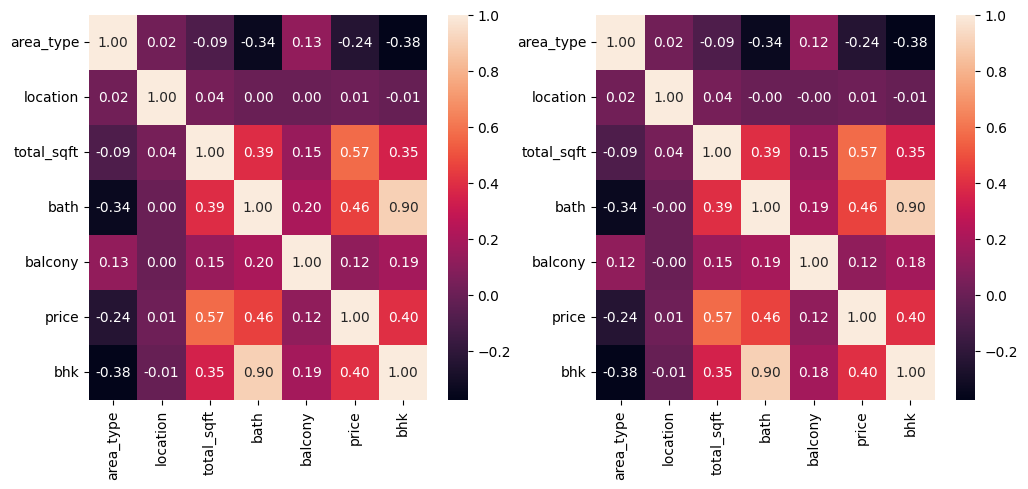

In [23]:
plt.figure(figsize=(12,5))
plt.subplot(121)
sns.heatmap(df3.corr(), annot=True, fmt='.2f')
plt.subplot(122)
sns.heatmap(df5.corr(), annot=True, fmt='.2f')

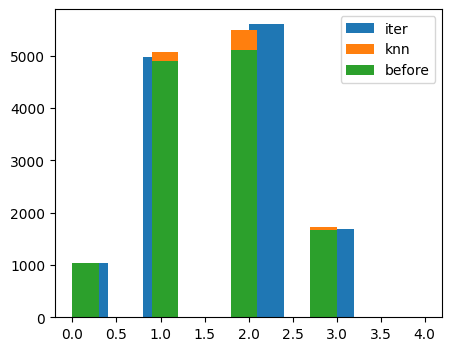

In [24]:
plt.figure(figsize=(5,4))
plt.hist(df4['balcony'],label='iter')
plt.hist(df5['balcony'],label='knn')
plt.hist(df3['balcony'],label='before')
plt.legend()

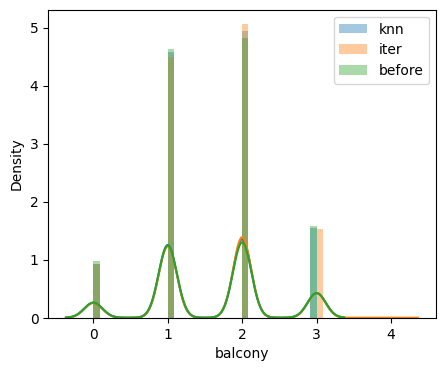

In [25]:
plt.figure(figsize=(5,4))
sns.distplot(df5['balcony'],label='knn')
sns.distplot(df4['balcony'],label='iter')
sns.distplot(df3['balcony'],label='before')
plt.legend()

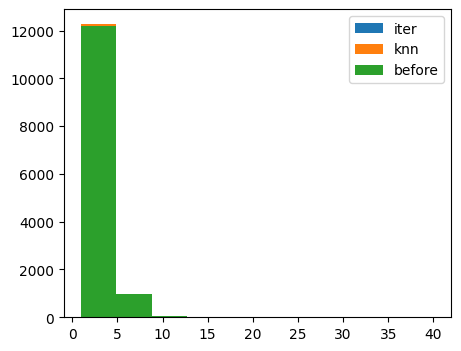

In [26]:
plt.figure(figsize=(5,4))
plt.hist(df4['bath'],label='iter')
plt.hist(df5['bath'],label='knn')
plt.hist(df3['bath'],label='before')
plt.legend()

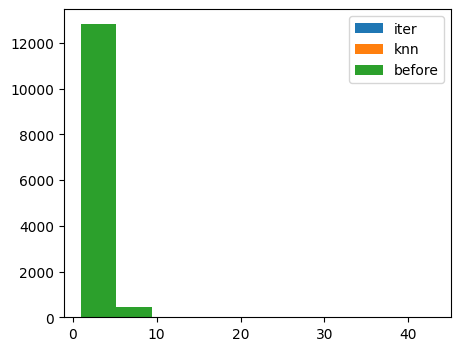

In [27]:
plt.figure(figsize=(5,4))
plt.hist(df4['bhk'],label='iter')
plt.hist(df5['bhk'],label='knn')
plt.hist(df3['bhk'],label='before')
plt.legend()

In [28]:
import sweetviz as sv
mr=sv.analyze(df5)
mr.show_html()

                                             |                                             | [  0%]   00:00 ->…

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


<h2 style='color:black'> removing duplicates</h2>

In [29]:
df5=df5.drop_duplicates()

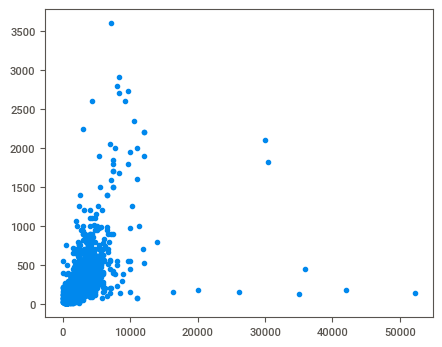

In [30]:
plt.figure(figsize=(5,4))
plt.scatter(df5['total_sqft'],df5['price'])

((array([-3.86778468, -3.64577197, -3.52402808, ...,  3.52402808,
          3.64577197,  3.86778468]),
  array([1.0000e+00, 1.0000e+00, 1.2500e+00, ..., 3.6000e+04, 4.2000e+04,
         5.2272e+04])),
 (840.660307774483, 1569.155625495167, 0.6635069758867801))

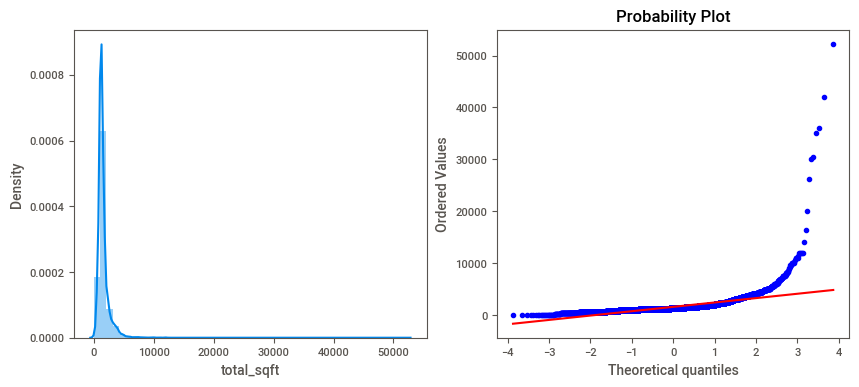

In [31]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.distplot(df5['total_sqft'])
plt.subplot(122)
stats.probplot(df5['total_sqft'], dist="norm", plot=plt)

<h2 style='color:black'> Feature transformation</h2>

In [32]:
df6=df5.copy()
pt = PowerTransformer(method='box-cox')
df6['total_sqft'] = pt.fit_transform(df6['total_sqft'].values.reshape(-1, 1))

((array([-3.86778468, -3.64577197, -3.52402808, ...,  3.52402808,
          3.64577197,  3.86778468]),
  array([-9.39562141, -9.39562141, -9.21945394, ...,  8.13807135,
          8.6168606 ,  9.31323744])),
 (0.9436498184442212, -1.2381068338624942e-16, 0.9433762687617965))

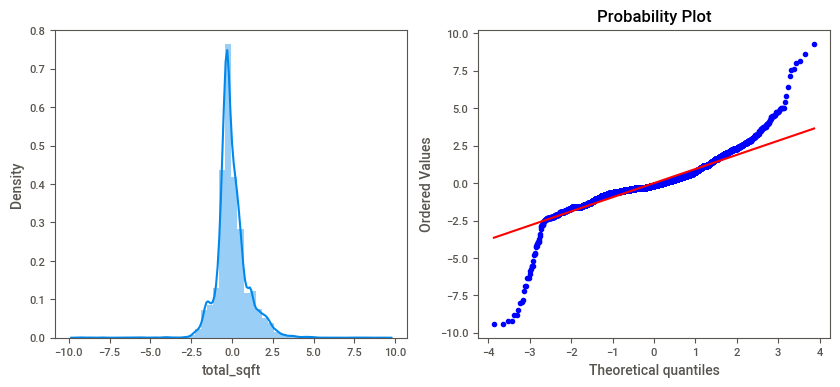

In [33]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.distplot(df6['total_sqft'])
plt.subplot(122)
stats.probplot(df6['total_sqft'], dist="norm", plot=plt)

In [34]:
upper_limit = df6['total_sqft'].mean() + 3*df6['total_sqft'].std()
lower_limit = df6['total_sqft'].mean() - 3*df6['total_sqft'].std()
df9 = df6[(df6['total_sqft'] < upper_limit) & (df6['total_sqft'] > lower_limit)]

In [35]:
df9.shape

(12476, 7)

{'whiskers': [<matplotlib.lines.Line2D at 0x1575f722750>,
 'caps': [<matplotlib.lines.Line2D at 0x1575f723a50>,
 'boxes': [<matplotlib.lines.Line2D at 0x1575f722090>],
 'medians': [<matplotlib.lines.Line2D at 0x1575f730c10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1575f731350>],
 'means': []}

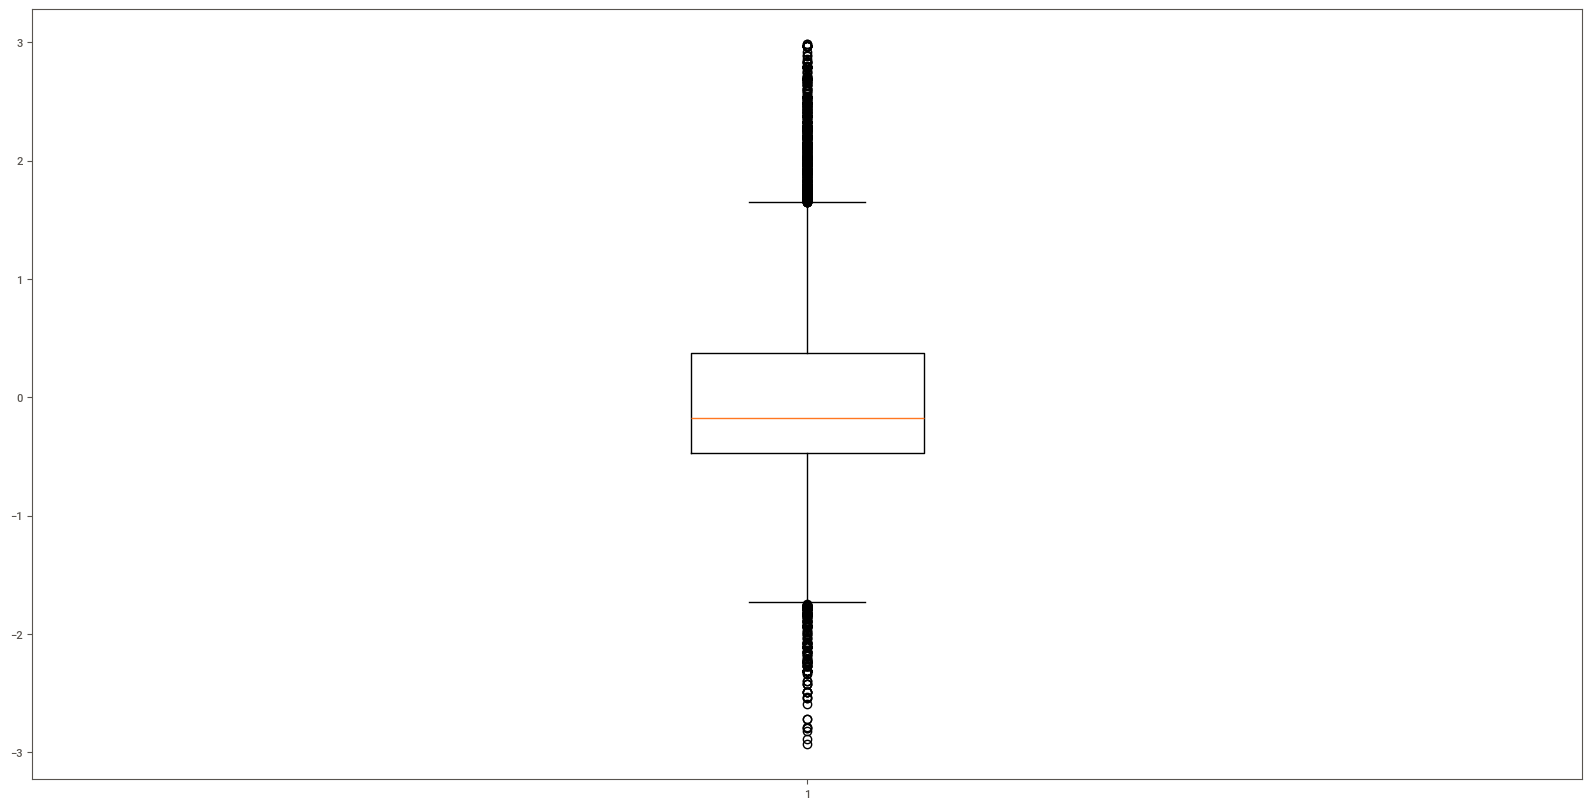

In [36]:
plt.boxplot(df9['total_sqft'])

((array([-3.86494594, -3.6427794 , -3.52094422, ...,  3.52094422,
          3.6427794 ,  3.86494594]),
  array([-2.93347182, -2.88696818, -2.81930369, ...,  2.97323136,
          2.98298451,  2.98431182])),
 (0.8379791995636645, -0.016440274019911195, 0.977975137295089))

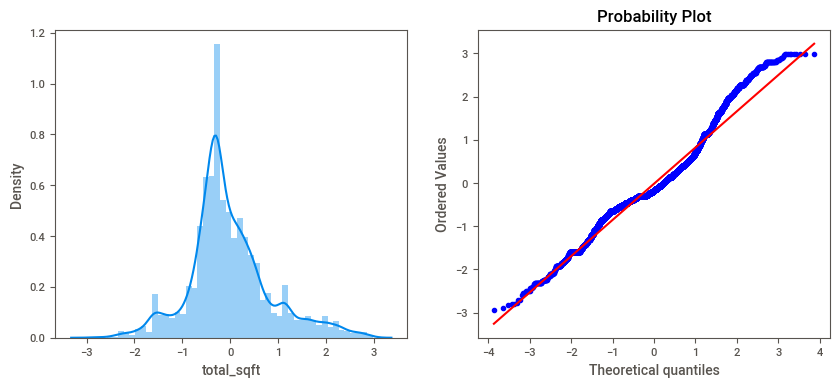

In [37]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.distplot(df9['total_sqft'])
plt.subplot(122)
stats.probplot(df9['total_sqft'], dist="norm", plot=plt)

In [38]:
df9['price'] = pt.fit_transform(df9['price'].values.reshape(-1, 1))

((array([-3.86494594, -3.6427794 , -3.52094422, ...,  3.52094422,
          3.6427794 ,  3.86494594]),
  array([-4.77614863, -4.6223362 , -4.44091233, ...,  3.1525882 ,
          3.24997774,  3.32954412])),
 (0.9964359364944703, -2.113047480275302e-15, 0.9961440295522462))

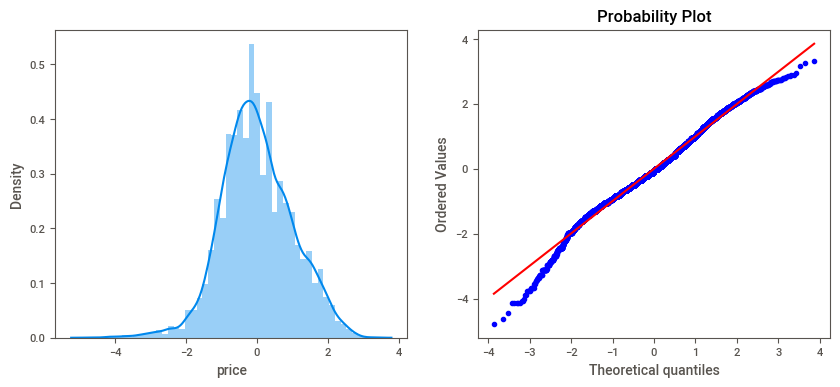

In [39]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.distplot(df9['price'])
plt.subplot(122)
stats.probplot(df9['price'], dist="norm", plot=plt)

In [40]:
upper_limit = df9['price'].mean() + 3*df9['price'].std()
lower_limit = df9['price'].mean() - 3*df9['price'].std()
df9 = df9[(df9['price'] < upper_limit) & (df9['price'] > lower_limit)]

((array([-3.86369048, -3.64145584, -3.51958023, ...,  3.51958023,
          3.64145584,  3.86369048]),
  array([-2.95859847, -2.95859847, -2.95859847, ...,  2.88975975,
          2.88975975,  2.96408352])),
 (0.9672432571008658, 0.016547049118642826, 0.9971615744043519))

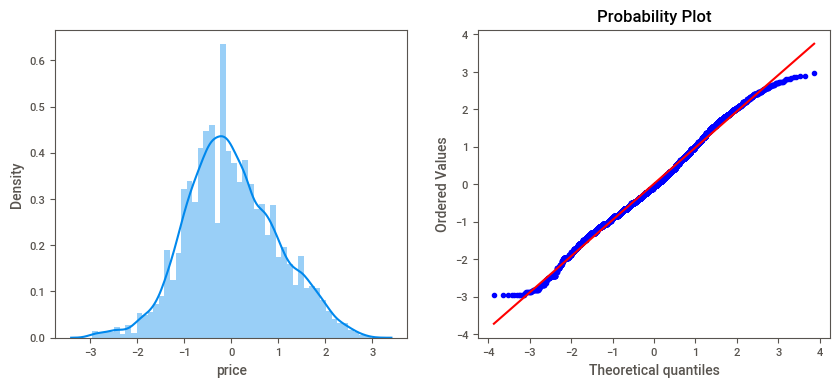

In [41]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.distplot(df9['price'])
plt.subplot(122)
stats.probplot(df9['price'], dist="norm", plot=plt)

In [42]:
df10=df9.drop(['bath'],axis='columns')

In [43]:
df10.head()

,area_type,location,total_sqft,balcony,price,bhk
0,3.0,405,-0.550383,1,-1.097499,2
1,1.0,303,1.301716,3,0.650695,4
2,2.0,1166,0.062642,3,-0.308518,3
3,3.0,743,0.173415,1,0.332191,3
4,3.0,702,-0.300732,1,-0.629341,2


<Axes: >

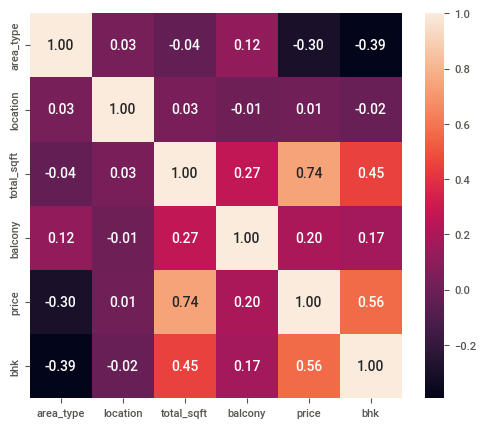

In [44]:
plt.figure(figsize=(6,5))
sns.heatmap(df10.corr(), annot=True, fmt='.2f')

<h2 style='color:black'> Feature scaling</h2>

In [45]:
scaler = StandardScaler()
df10 = pd.DataFrame(scaler.fit_transform(df10),columns=df10.columns)

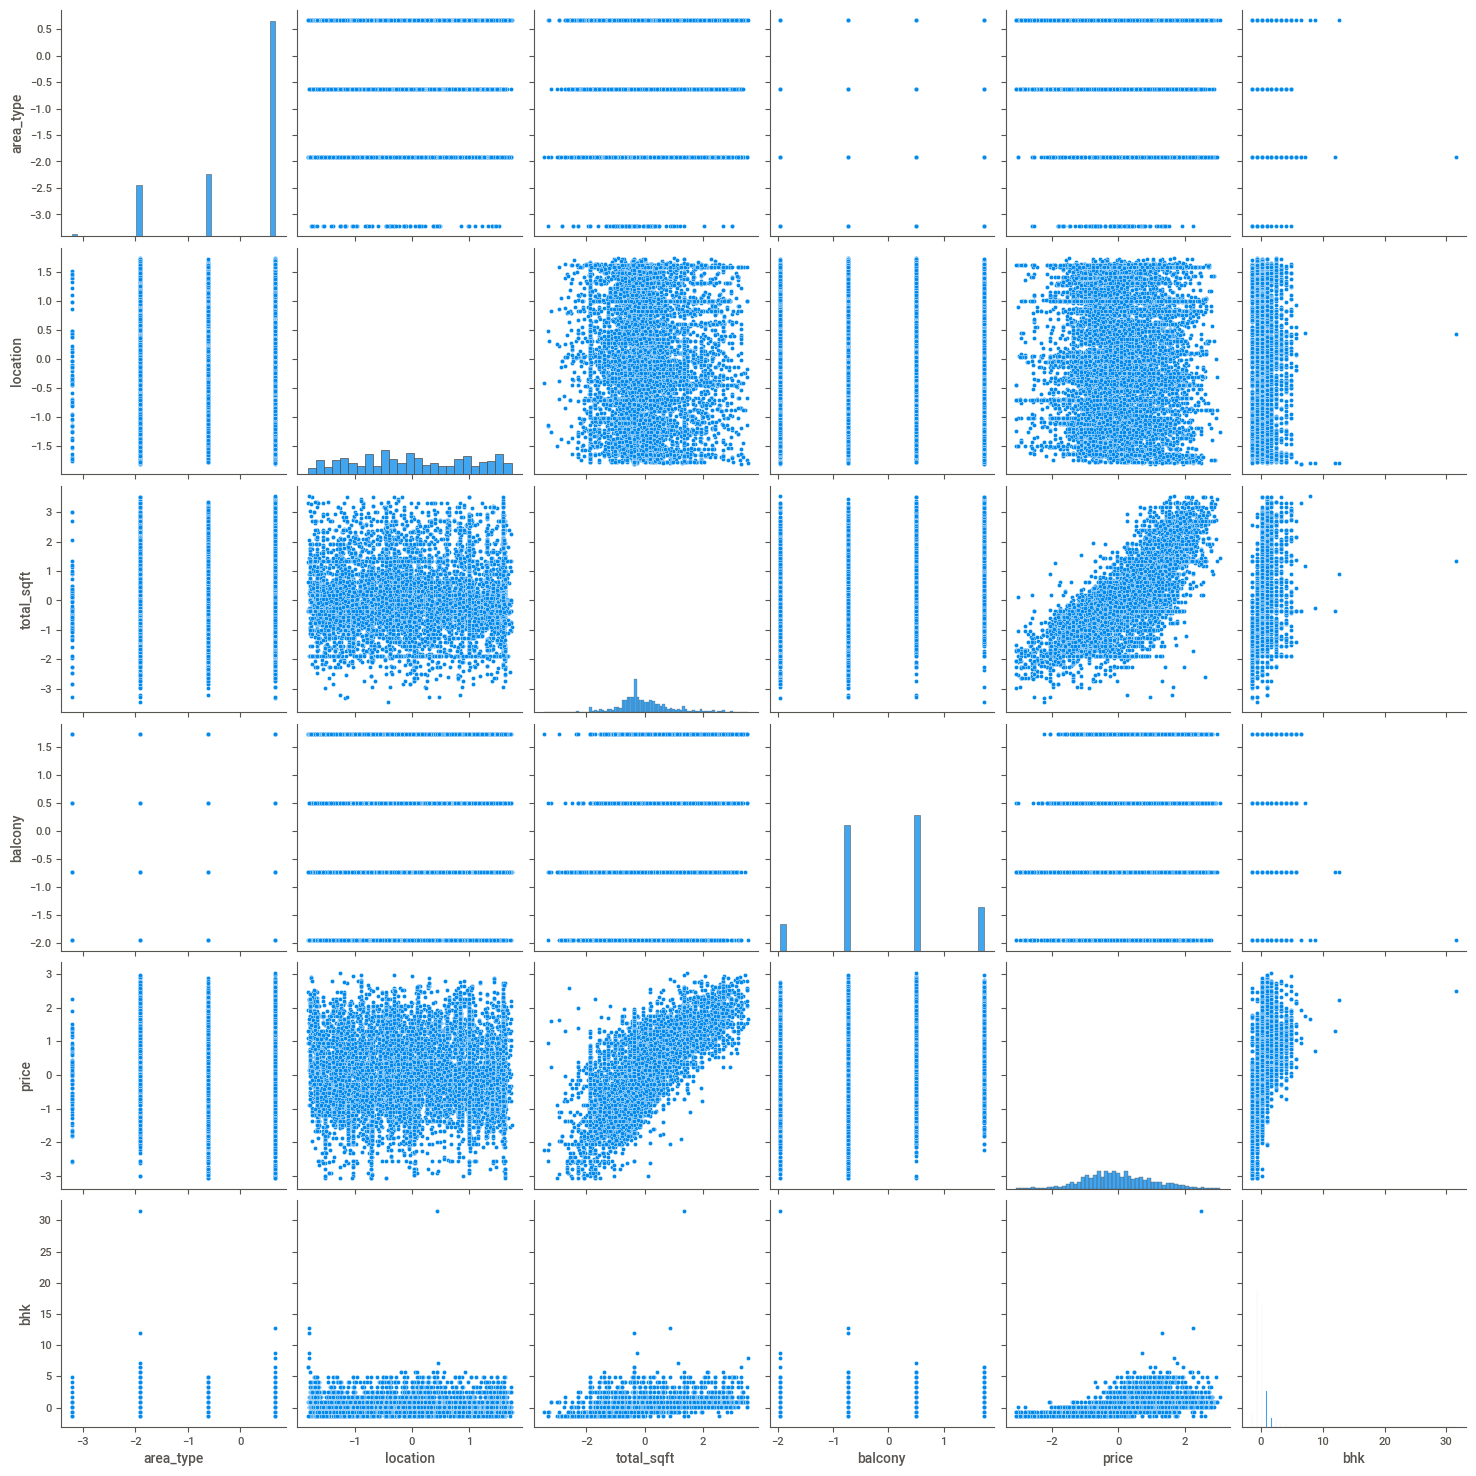

In [46]:
sns.pairplot(df10)

<h2 style='color:black'> Model training and evaluation</h2>

In [47]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=5)).mean()
    return rmse
    

def evaluation(y, predictions):
    mae = mean_absolute_error(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r_squared = r2_score(y, predictions)
    return mae, mse, rmse, r_squared

In [48]:
models = pd.DataFrame(columns=["Model","MAE","MSE","RMSE","R2 Score","RMSE (Cross-Validation)"])

In [49]:
df10.head()

,area_type,location,total_sqft,balcony,price,bhk
0,0.667029,-0.704910,-0.640078,-0.731321,-1.148844,-0.637961
1,-1.921422,-0.985013,1.546172,1.724287,0.653956,0.931587
2,-0.627197,1.384876,0.083547,1.724287,-0.335219,0.146813
3,0.667029,0.223273,0.214305,-0.731321,0.325504,0.146813
4,0.667029,0.110683,-0.345386,-0.731321,-0.666062,-0.637961


In [50]:
x=df10.drop(['price'],axis='columns')
y=df10['price']

In [51]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [52]:
def train_and_evaluate(model_name, model, x_train, y_train, x_test, y_test, models_df):
    # Train the model
    model.fit(x_train, y_train)
    
    # Make predictions
    predictions = model.predict(x_test)
    
    # Evaluate predictions
    mae, mse, rmse, r_squared = evaluation(y_test, predictions)
    
    # Perform cross-validation RMSE
    rmse_cross_val = rmse_cv(model)
    
    # Print results
    print(f"Model: {model_name}")
    print("MAE:", mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("R2 Score:", r_squared)
    print("RMSE Cross-Validation:", rmse_cross_val)
    print("-" * 30)
    
    # Add results to DataFrame
    new_row = pd.DataFrame([{
        "Model": model_name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2 Score": r_squared,
        "RMSE (Cross-Validation)": rmse_cross_val
    }])
    models_df = pd.concat([models_df, new_row], ignore_index=True)
    return models_df

In [53]:
# Dictionary of regression models
regression_models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet Regression": ElasticNet(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "Support Vector Regressor": SVR(),
    'xgb regressor' : XGBRegressor(),
    'adaboost_regressor' : AdaBoostRegressor()
}

# Iterate over models and evaluate
for model_name, model in regression_models.items():
    models = train_and_evaluate(model_name, model, x_train, y_train, x_test, y_test, models)

# Display the final results DataFrame
print(models)

Model: Linear Regression
MAE: 0.449325235850522
MSE: 0.33930912690543075
RMSE: 0.5825024694414872
R2 Score: 0.6567990897475953
RMSE Cross-Validation: 0.594439893531088
------------------------------
Model: Ridge Regression
MAE: 0.44932417363308996
MSE: 0.339305335690728
RMSE: 0.5824992151846455
R2 Score: 0.6568029244464988
RMSE Cross-Validation: 0.5944399397664639
------------------------------
Model: Lasso Regression
MAE: 0.7919704684815492
MSE: 0.9887403840434937
RMSE: 0.9943542548023283
R2 Score: -8.096717544603393e-05
RMSE Cross-Validation: 0.9999751269229625
------------------------------
Model: ElasticNet Regression
MAE: 0.7040998049584187
MSE: 0.7751001355367514
RMSE: 0.880397714409091
R2 Score: 0.2160096768422124
RMSE Cross-Validation: 0.8879443012503255
------------------------------
Model: Decision Tree Regressor
MAE: 0.4424848248703939
MSE: 0.40256901169010145
RMSE: 0.6344832635224521
R2 Score: 0.5928136312998113
RMSE Cross-Validation: 0.6452606139718011
--------------------

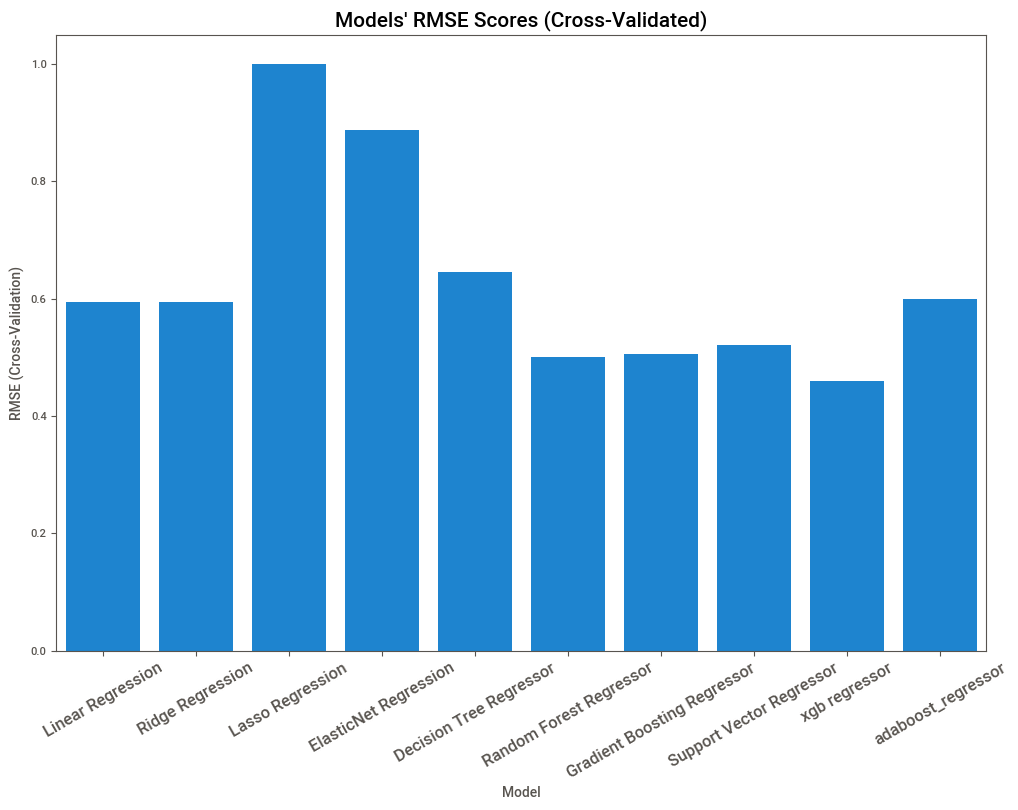

In [54]:
plt.figure(figsize=(12,8))
sns.barplot(x=models["Model"], y=models["RMSE (Cross-Validation)"])
plt.title("Models' RMSE Scores (Cross-Validated)", size=15)
plt.xticks(rotation=30, size=12)
plt.show()

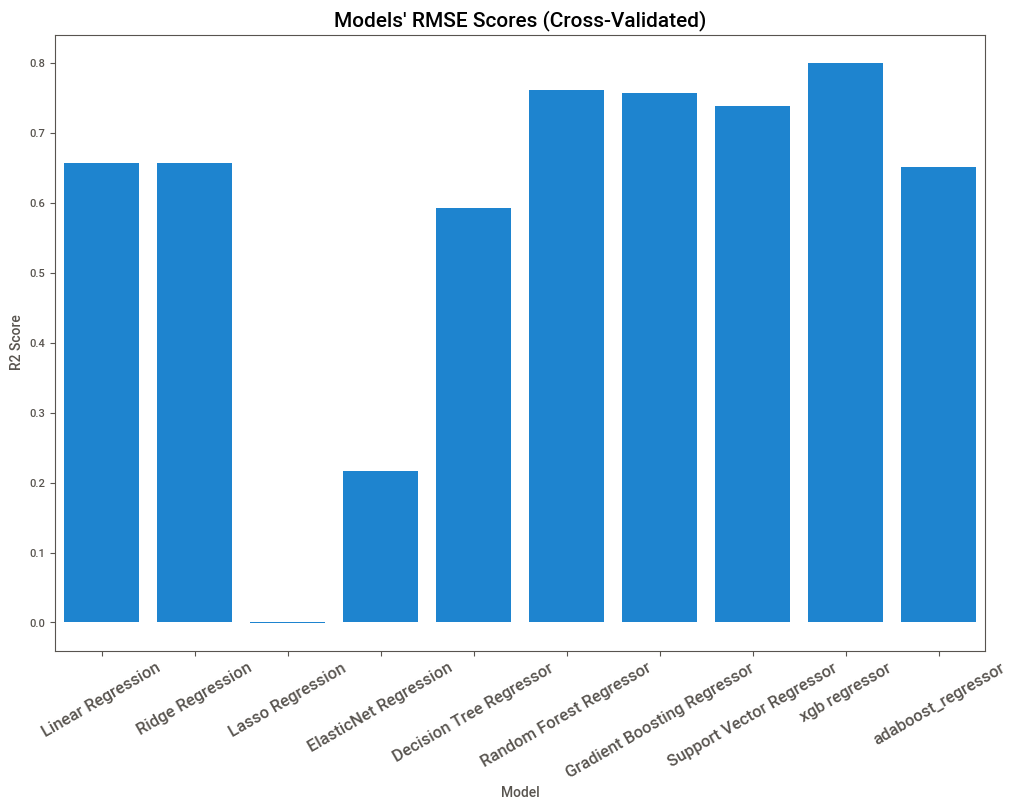

In [55]:
plt.figure(figsize=(12,8))
sns.barplot(x=models["Model"], y=models["R2 Score"])
plt.title("Models' RMSE Scores (Cross-Validated)", size=15)
plt.xticks(rotation=30, size=12)
plt.show()